In [ ]:
!pip install dython

# Importing the required modules.

In [4]:
# Modules required for data handling and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style("whitegrid")

# Modules required for accessing the file system.
import os

# Modules used for model training and transfer learning
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.applications as cnns
from tensorflow.keras import Model

# Disabling logging
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Constants
TRAIN_CSV_DIR = "/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/RFMiD_Training_Labels.csv"
TEST_CSV_DIR = "/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/RFMiD_Testing_Labels.csv"
VAL_CSV_DIR = "/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv"

In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [6]:
tf.debugging.set_log_device_placement(False)

# Exploratory Data Analysis

Since, there are too many classes there is a chance of class imbalance to verify it we analyse the class distribution.

In [7]:
train_labels = pd.read_csv(TRAIN_CSV_DIR)
test_labels = pd.read_csv(TEST_CSV_DIR)
val_labels = pd.read_csv(VAL_CSV_DIR)

In [8]:
train_labels.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


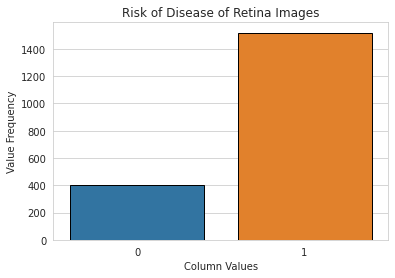

In [9]:
disease_risk_col = dict(train_labels["Disease_Risk"].value_counts())
col_labels = list(disease_risk_col.keys())
label_freq = list(disease_risk_col.values())
sns.barplot(x = col_labels,
            y = label_freq,
            edgecolor = "black")
plt.title("Risk of Disease of Retina Images")
plt.xlabel("Column Values")
plt.ylabel("Value Frequency")
plt.show()

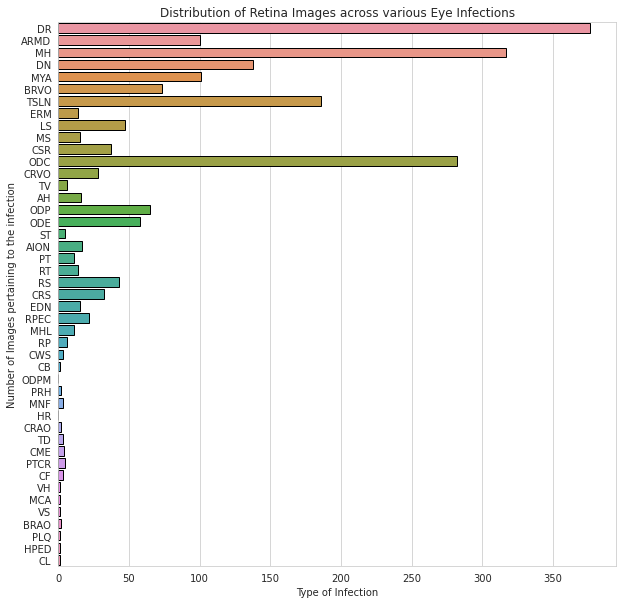

In [10]:
infected_retinas = dict(train_labels.drop(["ID", "Disease_Risk"], axis=1).sum())
retina_infections = list(infected_retinas.keys())
infection_freq = list(infected_retinas.values())
plt.figure(figsize = (10,10))
sns.barplot(y = retina_infections,
            x = infection_freq,
            edgecolor = "black",
            orient = "h")
plt.title("Distribution of Retina Images across various Eye Infections")
plt.xlabel("Type of Infection")
plt.ylabel("Number of Images pertaining to the infection")
plt.show()

From the class distribution we can make the following inferences:
- The diseases OPDM and HR have no samples for training and hence will be dropped. 
- The aim of the model is to predict different diseases so for multilabel classification, Disease Risk column is not relevant. However, we can built a binary classifier for predicting whether the retinal image poses a risk of any disease or not. Based on the outcome of the binary classifier, we will use the multilabel classifier.
- We also observe that there is a lot of class imbalance and hence, for classes below a certain threshold we will consider them into a category of "Other" category.

# Training a binary classifier for Disease Risk Feature

In [11]:
TRAIN_IMG_DIR="/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/Training"
TEST_IMG_DIR = "/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test"
VAL_IMG_DIR = "/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation"
def id_to_path(id : int, IMG_DIR : str):
    return os.path.join(IMG_DIR, str(id) + ".png")

In [12]:
train_labels["IMG_DIR"] = TRAIN_IMG_DIR
train_labels["IMG_DIR"] = train_labels.apply(lambda x: id_to_path(x.ID, x.IMG_DIR), 
                                             axis=1)
test_labels["IMG_DIR"] = TEST_IMG_DIR
test_labels["IMG_DIR"] = test_labels.apply(lambda x: id_to_path(x.ID, x.IMG_DIR), 
                                           axis=1)
val_labels["IMG_DIR"] = VAL_IMG_DIR
val_labels["IMG_DIR"] = val_labels.apply(lambda x: id_to_path(x.ID, x.IMG_DIR), 
                                         axis=1)

In [13]:
class ImagePreprocessor:
    def __init__(self, cnn_variant):
        self.cnn_variant = cnn_variant
        self.train_gen = None
        self.test_gen = None
        self.val_gen = None
        
    def create_generators(self):
        self.train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input,
        )

        self.test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )

        self.val_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )
        
    def preprocess(self):
        train_images = self.train_gen.flow_from_dataframe(
              train_labels,
              x_col="IMG_DIR", 
              y_col="Disease_Risk",
              target_size=(200,200),
              color_mode='rgb',
              batch_size=32,
              class_mode="binary",
              shuffle=True
        )

        val_images = self.val_gen.flow_from_dataframe(
              test_labels,
              x_col="IMG_DIR", 
              y_col="Disease_Risk",
              target_size=(200,200),
              color_mode='rgb',
              batch_size=32,
              class_mode="binary",
              shuffle=True
        )

        test_images = self.test_gen.flow_from_dataframe(
              val_labels,
              x_col="IMG_DIR", 
              y_col="Disease_Risk",
              color_mode='rgb',
              target_size=(200,200),
              batch_size=32,
              class_mode="binary",
              shuffle=True
        )

        return train_images, val_images, test_images

In [14]:
preprocessor = ImagePreprocessor(cnns.efficientnet)

In [15]:
preprocessor.create_generators()

In [16]:
train_labels["Disease_Risk"] = train_labels["Disease_Risk"].astype(str)
test_labels["Disease_Risk"] = test_labels["Disease_Risk"].astype(str)
val_labels["Disease_Risk"] = val_labels["Disease_Risk"].astype(str)

In [17]:
train, val, test = preprocessor.preprocess()

Found 1920 validated image filenames belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.


In [25]:
class TransferLearning:

    def __init__(self, train, val) -> None:
        self.train = train
        self.val = val
        self.model = None
        self.history = None
        self.fine_tune_from = 100

    def load_model(self):
        self.model = cnns.efficientnet.EfficientNetB4(include_top = False, 
                                            input_shape = (200,200,3))
    
    def mark_layers_non_trainable(self):
        for layer in self.model.layers[:self.fine_tune_from]:
            layer.trainable = False
        
        for layer in self.model.layers[self.fine_tune_from:]:
            layer.trainable = True
    
    def add_final_layer(self):
        self.x = Flatten()(self.model.output)
        self.x = Dense(1000, activation='relu')(self.x)
        self.predictions = Dense(1, activation = 'sigmoid')(self.x)

    def compile_model(self):
        self.model = Model(inputs = self.model.input, 
                           outputs = self.predictions)
        self.model.compile(optimizer='adam', 
                           loss="binary_crossentropy", 
                           metrics=['accuracy'])
    
    def train_model(self):
        self.history = self.model.fit(train,
                                      batch_size=32, 
                                      epochs=10, 
                                      validation_data=self.val)
    
    def plot_history(self):
        fig, axs = plt.subplots(2, 1, figsize=(15,15))
        axs[0].plot(self.history.history['loss'])
        axs[0].plot(self.history.history['val_loss'])
        axs[0].title.set_text('Training Loss vs Validation Loss')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].legend(['Train','Val'])

        axs[1].plot(self.history.history['accuracy'])
        axs[1].plot(self.history.history['val_accuracy'])
        axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend(['Train', 'Val'])



In [26]:
modelbuilder = TransferLearning(train, val)

In [27]:
modelbuilder.load_model()

In [28]:
modelbuilder.mark_layers_non_trainable()

In [29]:
modelbuilder.add_final_layer()

In [30]:
modelbuilder.compile_model()

In [31]:
modelbuilder.train_model()

Epoch 1/10
60/60 [==============================] - 320s 5s/step - loss: 2.0753 - accuracy: 0.7620 - val_loss: 0.2913 - val_accuracy: 0.7906
Epoch 2/10
60/60 [==============================] - 299s 5s/step - loss: 0.2956 - accuracy: 0.8490 - val_loss: 0.2562 - val_accuracy: 0.9172
Epoch 3/10
60/60 [==============================] - 308s 5s/step - loss: 0.2499 - accuracy: 0.8891 - val_loss: 0.2569 - val_accuracy: 0.8906
Epoch 4/10
60/60 [==============================] - 324s 5s/step - loss: 0.2117 - accuracy: 0.9083 - val_loss: 0.2239 - val_accuracy: 0.8938
Epoch 5/10
60/60 [==============================] - 325s 5s/step - loss: 0.1511 - accuracy: 0.9438 - val_loss: 0.2719 - val_accuracy: 0.8938
Epoch 6/10
60/60 [==============================] - 323s 5s/step - loss: 0.1173 - accuracy: 0.9557 - val_loss: 0.2657 - val_accuracy: 0.9016
Epoch 7/10
60/60 [==============================] - 327s 5s/step - loss: 0.0926 - accuracy: 0.9703 - val_loss: 0.3185 - val_accuracy: 0.8844
Epoch 8/10
60